In [2]:
import datetime as dt
import geopandas as gpd
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from hdbscan import HDBSCAN
from sklearn.preprocessing import MinMaxScaler

import sys
import os

# Añadir la carpeta 'utils' al path
utils_path = os.path.abspath(os.path.join("..", "utils"))
if utils_path not in sys.path:
    sys.path.append(utils_path)
from utils import *

#### DESCARGA DE DATOS
  
Puedes descargar directamente los archivos desde los siguientes enlaces o ejecutar el código de abajo.  
Estos archivos se descargan en formato zip y se deben descomprimir directamente en la carpeta 'data_sample'.

[EFFIS](https://forest-fire.emergency.copernicus.eu/) (European Forest Fire Information System) la superficie quemada en formato shapefile:
- [Burn Areas database](https://maps.effis.emergency.copernicus.eu/effis?service=WFS&request=getfeature&typename=ms:modis.ba.poly&version=1.1.0&outputformat=SHAPEZIP) <- Click para descarga directa

Eurostat ([GISCO](https://ec.europa.eu/eurostat/web/gisco/overview)) un shapefile para obtener el nombre en inglés de los países y sus códigos internacionales:
- [Countries](https://gisco-services.ec.europa.eu/distribution/v2/countries/shp/CNTR_RG_20M_2024_4326.shp.zip) <- Click para descarga directa

In [2]:
# Primero creamos el directorio en dónde se guardarán los datos
data_directory = './src/data_sample'
os.makedirs(data_directory, exist_ok=True)

In [3]:
# Descagamos los shapefiles (tamaño aproximado de EFFIS <200 MB)
response = ''
while response != 'Y' and response != 'n':
    response = input('¿Estás seguro d que quieres descargar los datos?(Y/n)')
if response == 'Y':
    urls = {
        'EFFIS':'https://maps.effis.emergency.copernicus.eu/effis?service=WFS&request=getfeature&typename=ms:modis.ba.poly&version=1.1.0&outputformat=SHAPEZIP',
        'Countries':'https://gisco-services.ec.europa.eu/distribution/v2/countries/shp/CNTR_RG_20M_2024_4326.shp.zip'
    }

    for name, url in urls.items():
        print(f'Obteniendo {name}:')
        download(name, url, data_directory)
        print()

#### CARGA DE DATOS

Los datos necesarios se encuentran en formato shapefile, el cual se divide en 4 archivos diferentes.  
Para importarlos a un dataframe usaremos geopandas.

In [4]:
effis = gpd.read_file(os.path.join(data_directory,'modis.ba.poly.shp'))
countries = gpd.read_file(os.path.join(data_directory, 'CNTR_RG_20M_2024_4326.shp'))

In [5]:
effis.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 76819 entries, 0 to 76818
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id          76819 non-null  object  
 1   FIREDATE    76819 non-null  object  
 2   LASTUPDATE  76819 non-null  object  
 3   COUNTRY     76817 non-null  object  
 4   PROVINCE    76819 non-null  object  
 5   COMMUNE     76819 non-null  object  
 6   AREA_HA     76819 non-null  object  
 7   BROADLEA    76007 non-null  object  
 8   CONIFER     76007 non-null  object  
 9   MIXED       76007 non-null  object  
 10  SCLEROPH    76007 non-null  object  
 11  TRANSIT     76007 non-null  object  
 12  OTHERNATLC  76007 non-null  object  
 13  AGRIAREAS   76007 non-null  object  
 14  ARTIFSURF   76007 non-null  object  
 15  OTHERLC     76007 non-null  object  
 16  PERCNA2K    76819 non-null  object  
 17  CLASS       76819 non-null  object  
 18  geometry    76819 non-null  geometry
d

In [6]:
effis.head()

,id,FIREDATE,LASTUPDATE,COUNTRY,PROVINCE,COMMUNE,AREA_HA,BROADLEA,CONIFER,MIXED,SCLEROPH,TRANSIT,OTHERNATLC,AGRIAREAS,ARTIFSURF,OTHERLC,PERCNA2K,CLASS,geometry
0,2,2016-08-28 00:00:00,2022-01-26 11:57:54.973474,AL,Korcë,Konispol,67,0,0,0,19.402985074597908,16.417910447736688,10.447761194014257,53.731343283501886,0,0,0,FireSeason,"POLYGON ((20.18901 39.74908, 20.18909 39.75006..."
1,888,2016-08-08 00:00:00,2022-01-26 11:57:54.973474,PT,Área Metropolitana do Porto,Covelo de Paivó e Janarde,26593,0.6020922706404734,0.2558892150222012,0.2220215247986746,0,56.893956498833234,38.661849928501404,3.2174305712350297,0.14675999096861542,0,9.843358251326316,FireSeason,"POLYGON ((-8.06251 40.84474, -8.06033 40.8436,..."
2,19,2016-08-11 00:00:00,2022-01-26 11:57:54.973474,PT,Tâmega e Sousa,Caçarilhe e Infesta,81,0,1.17647058823391,0,0,67.05882352933287,19.99999999997647,11.7647058823391,0,0,0,FireSeason,"POLYGON ((-8.05657 41.40623, -8.05945 41.4048,..."
3,87,2016-07-27 00:00:00,2022-01-26 11:57:54.973474,TR,??rnak,N.A.,72,0,0,0,0,70.83333333323495,22.222222222191355,0,6.9444444444348,0,0,FireSeason,"POLYGON ((42.50247 37.53773, 42.5029 37.53451,..."
4,368,2016-08-24 00:00:00,2022-01-26 11:57:54.973474,IT,Genova,Bogliasco,267,11.654135338341485,5.639097744358783,0.37593984962391885,0,7.894736842102295,74.06015037591202,0.37593984962391885,0,0,5.453094633641743,FireSeason,"POLYGON ((9.06157 44.39255, 9.06266 44.39417, ..."


#### FILTRADO DE DATOS

A continuación realiamos un filtrado de países para acotar a nuestro área de interés

In [7]:
# Nos fijamos en que el nombre de los países de EFFIS está codificado, 
# por lo que vamos a proceder a decodificarlo usando el shapefile de Eurostat.
# Además aprovechamos y filtramos por los países de la Europa geográfica:
# https://en.wikipedia.org/wiki/United_Nations_geoscheme?utm_source=chatgpt.com

# Excluiremos a Rusia Bielorrusia y Moldavia or carecer de datos y a Ucrania debido a la guerra 

'''
Países UE:
https://european-union.europa.eu/principles-countries-history/eu-countries_es#header_countries_list

'''
eu_countries = [
    "Germany",
    "Austria",
    "Belgium",
    "Bulgaria",
    "Czechia",
    # "Cyprus",
    "Croatia",
    "Denmark",
    "Slovakia",
    "Slovenia",
    "Spain",
    "Estonia",
    "Finland",
    "France",
    "Greece",
    "Hungary",
    "Ireland",
    "Italy",
    "Latvia",
    "Lithuania",
    "Luxembourg",
    "Malta",
    "Netherlands",
    "Poland",
    "Portugal",
    "Romania",
    "Sweden",
    'Switzerland',
    'Norway','United Kingdom',
    'North Macedonia', 'Serbia', 'Albania', 'Bosnia and Herzegovina', 'Montenegro', 'Kosovo'
]

# Filtramos el dataset por los países de nuestra lista
countries = countries[countries.NAME_ENGL.isin(eu_countries)]
effis_eu = effis[effis.COUNTRY.isin(filtro_paises(countries, eu_countries))] 

# Creamos un nuevo campo para el código del país (COUNTRY_ID) y sustituimos el campo 'COUNTRY' con el nombre en inglés
effis_eu['COUNTRY_ID'] = effis_eu.COUNTRY
effis_eu['COUNTRY'] = nombre_pais(countries, effis_eu.COUNTRY)

No se encuentra Kosovo


c:\Users\Usuario\Documents\GitHub\ML_EFFIS\.venv\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


#### CÁLCULO CENTROIDE Y COORDENADAS

In [8]:
# Reproyectamos capa, calculamos centroides y extraemos coordenadas

effis_eu = effis_eu.to_crs(4326)
effis_eu['LAT'], effis_eu['LON'] = effis_eu.centroid.y, effis_eu.centroid.x

C:\Users\Usuario\AppData\Local\Temp\ipykernel_13316\3257089057.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  effis_eu['LAT'], effis_eu['LON'] = effis_eu.centroid.y, effis_eu.centroid.x


In [9]:
# Establecemos nuestro marco de trabajo y filtramos el dataset 
# eliminando así los archipiélagos e islas atlánticas

lon_min = -10.5 # Dunmore Head, Irlanda
lon_max = 31.6 # Ilomantsi, Finlandia
lat_min = 34.8 # Isla de Gavdos, Grecia
lat_max = 71.2 # Cabo Norte, Noruega

effis_eu = effis_eu.loc[effis_eu.LAT.between(lat_min, lat_max) & effis_eu.LON.between(lon_min, lon_max)]

#### CÁLCULO DE TIEMPO

In [10]:
# Pasamos las columnas de inicio de incendio y última actualización a datetime 
effis_eu.FIREDATE = pd.to_datetime(effis_eu.FIREDATE, format='ISO8601')
effis_eu.LASTUPDATE = pd.to_datetime(effis_eu.LASTUPDATE, format='ISO8601')

# Creamos una variable para los años y eliminamos los incendios de 2025
effis_eu['YEAR'] = effis_eu.FIREDATE.dt.year
effis_eu = effis_eu[effis_eu.YEAR < 2025]

# Calculamos la duración del incendio
effis_eu['DURATION'] = effis_eu.LASTUPDATE - effis_eu.FIREDATE

# Calculamos día juliano
effis_eu['DAY_YEAR'] = effis_eu.FIREDATE.dt.dayofyear

In [11]:
# Revisamos los datos de 'DURATION', pero no parecen coincidir con la duración del incendio
# Probablemente 'LASTUPDATE' esté ligado a la fecha de extinción del incendio, esto es, 
# cuando la autoridad competente lo determina, o última fecha que se detecta la 'huella' del incendio.
# En cualquier caso, no nos sirve este dato ya que se buscaba valorar la velocidad de propagación 

effis_eu.DURATION.dt.days.describe()

count    40941.000000
mean       355.491439
std        539.566251
min        -24.000000
25%          5.000000
50%         24.000000
75%        527.000000
max       2180.000000
Name: DURATION, dtype: float64

#### CONVERSIÓN VARIABLES NUMÉRICAS

In [12]:
effis_eu.AREA_HA = effis_eu.AREA_HA.astype(int)

# Las siguientes variables hacen referencia al tipo de superficie quemada
# expresada en porcentaje del área del incendio

var_float = ['BROADLEA', 'CONIFER', 'MIXED', 'SCLEROPH', 'TRANSIT',
       'OTHERNATLC', 'AGRIAREAS', 'ARTIFSURF', 'OTHERLC']

for variable in var_float:
    effis_eu[variable] = effis_eu[variable].astype(float)

#### REORDENAMOS Y LIMPIAMOS FEATURES

In [13]:
effis_eu = effis_eu[['FIREDATE','DAY_YEAR','YEAR',
                    'COUNTRY_ID','COUNTRY','PROVINCE','COMMUNE',
                    'AREA_HA','BROADLEA','CONIFER','MIXED',
                    'SCLEROPH','TRANSIT','OTHERNATLC',
                    'AGRIAREAS','ARTIFSURF','OTHERLC',
                    'LAT','LON']]
effis_eu.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40941 entries, 0 to 66299
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   FIREDATE    40941 non-null  datetime64[ns]
 1   DAY_YEAR    40941 non-null  int32         
 2   YEAR        40941 non-null  int32         
 3   COUNTRY_ID  40939 non-null  object        
 4   COUNTRY     40941 non-null  object        
 5   PROVINCE    40941 non-null  object        
 6   COMMUNE     40941 non-null  object        
 7   AREA_HA     40941 non-null  int64         
 8   BROADLEA    40623 non-null  float64       
 9   CONIFER     40623 non-null  float64       
 10  MIXED       40623 non-null  float64       
 11  SCLEROPH    40623 non-null  float64       
 12  TRANSIT     40623 non-null  float64       
 13  OTHERNATLC  40623 non-null  float64       
 14  AGRIAREAS   40623 non-null  float64       
 15  ARTIFSURF   40623 non-null  float64       
 16  OTHERLC     40623 non-null 

#### SELECCIÓN DE FEATURES 

In [14]:
# Revisamos la distribución de las features, y vemos que los porcentajes de tipos de área quemada (bosques, agrícolas, artificiales, etc)
# no aporta mucha información, ya que sólo la categoría 'OTHERNATLC' ('Other Natural Landscapes') representa el 97% de la superficie quemada
# en un 25 % de los datos, y al menos el 40% en la mitad de ellos. Mientras que el resto de las categorías son meramente residuales. 

effis_eu.describe().T

,count,mean,min,25%,50%,75%,max,std
FIREDATE,40941,2021-10-29 13:11:39.961673984,2016-02-07 00:00:00,2020-08-17 11:18:00,2022-03-19 11:17:00,2023-06-01 01:00:00,2024-12-31 12:46:00,NaN
DAY_YEAR,40941.0,153.150973,1.0,80.0,147.0,228.0,366.0,89.418111
YEAR,40941.0,2021.40937,2016.0,2020.0,2022.0,2023.0,2024.0,2.114903
AREA_HA,40941.0,136.932146,0.0,8.0,26.0,74.0,96610.0,1023.268714
BROADLEA,40623.0,15.489652,0.0,0.0,0.0,16.666667,100.0,28.787398
CONIFER,40623.0,3.29681,0.0,0.0,0.0,0.0,100.0,15.480564
MIXED,40623.0,2.42985,0.0,0.0,0.0,0.0,100.0,12.803305
SCLEROPH,40623.0,6.576687,0.0,0.0,0.0,0.0,100.0,21.591243
TRANSIT,40623.0,12.663559,0.0,0.0,0.0,4.098693,100.0,27.247327
OTHERNATLC,40623.0,45.698428,0.0,0.0,40.0,97.959184,100.0,44.065258


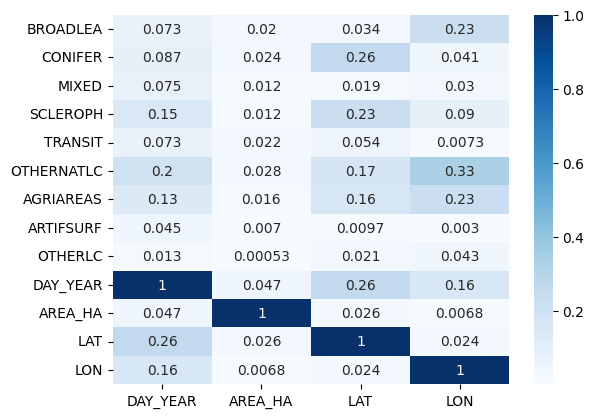

In [15]:
# Debido a la baja representatividad de las categorías de tipo de superficie quemada, haremos dos modelados:
# uno con la variables básicas de ubicación y tamaño de incendio, y un segundo modelado con la tipología de superficie quemada

features_base = ['DAY_YEAR','AREA_HA','LAT','LON']

# Para seleccionar las segundas variables miraremos la correlación de éstas con las principales

sns.heatmap(effis_eu[var_float + features_base].corr()[features_base].abs(), annot=True, fmt= ".2g", cmap='Blues');

Vayamos por partes:
- **BROADLEA** y **CONIFER** nos ayudarán a sesgar en diferentes longitudes y latitudes respectivamente
- **SCLEROPH** tiene una correlación similar a **CONIFER**
- **OTHERNATLC** tiene un 33% de correlación con **LON**, un 20% con **DAY_YEAR** y un poco menos con **LAT**
- **AGRIAREAS** tiene una distribución similar a **OTHERNATLC**, aunque con valores algo menores

Ahora comprobaremos correlación entre las diferentes variables y ver si podemos desartar alguna más. 
La idea es que en clusteres que abarquen un área muy grande, estas variables ayuden al algoritmo a diferenciar tipos de incendios, 
por ejemplo, en latitudes altas en dónde el número de incendios es menor. 

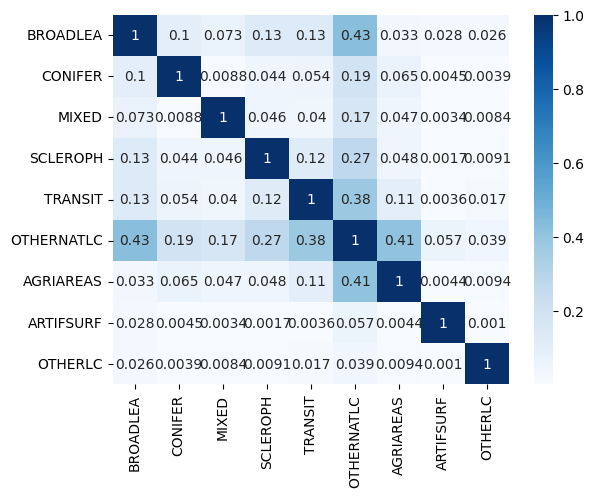

In [16]:
# Como vemos son variables independientes

sns.heatmap(effis_eu[var_float].corr().abs(), annot=True, fmt= ".2g", cmap='Blues');

In [53]:
# En resumen nos quedamos con las variables base y las mencionadas anteriormente de entre las de tipo de superficie quemada

features_base = ['DAY_YEAR','AREA_HA','LAT','LON']
features_type = features_base + ['BROADLEA', 'CONIFER', 'SCLEROPH','OTHERNATLC', 'AGRIAREAS']

#### TRANSFORMACIÓN DE FEATURES

Distribución de las variables

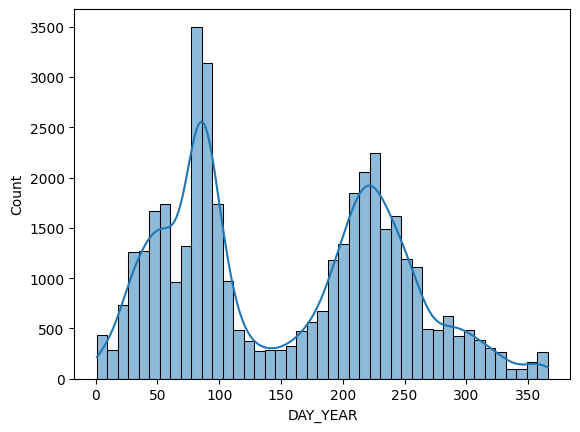

In [18]:
# Estudiamos ahora la distribución de incendios a lo largo del año, ya que se trata de una variable cíclica,
# y observamos que hay dos picos: en primavera y en verano

sns.histplot(effis_eu, x='DAY_YEAR', kde=True);

In [19]:
# La pregunta es, si manteniendo el orden cronológico de días, partiremos alguna agrupación temporal de incendios
# Para salir de dudas miramos los 10 días con menor número de incendios, y comprobamos que efectivamente se producen menos en diciembre
# Por tanto podemos dejar esta variable como está y asumiendo un 'parón' de incendios en esta época

def day2date(day:int):
    date = pd.to_datetime(day, format='%j').strftime('%d-%b')
    return date

for day in effis_eu.groupby('DAY_YEAR')['AREA_HA'].count().nsmallest(10).index:
    print(day2date(day))

08-Dec
01-Jan
04-Dec
05-Dec
02-Dec
09-Dec
13-Dec
06-Dec
16-Dec
07-Dec


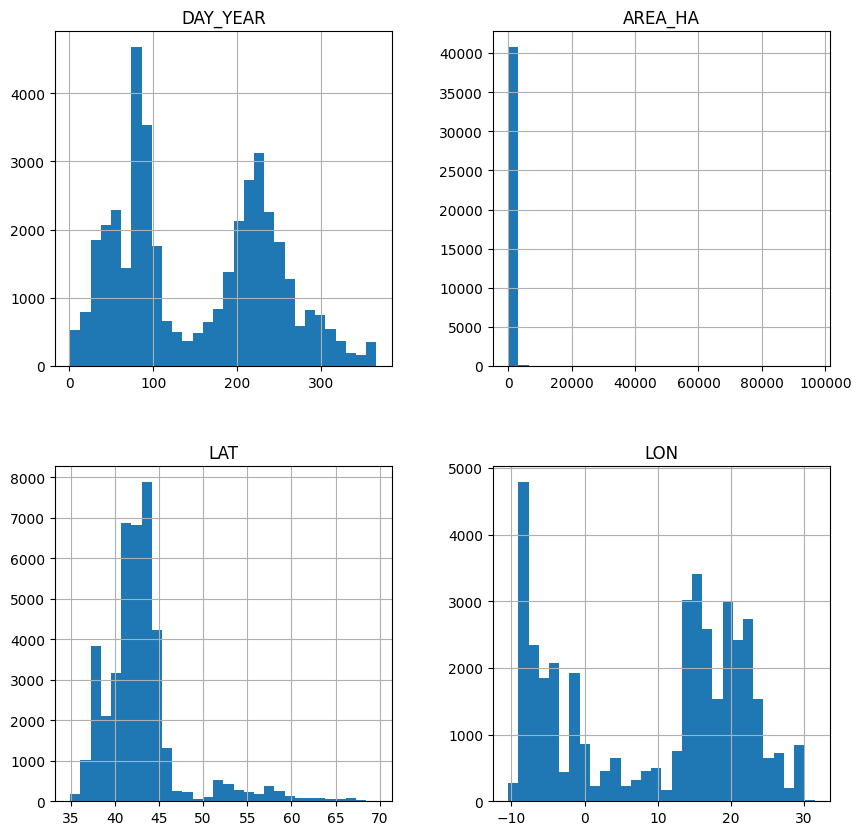

In [20]:
# Observamos ahora la distribución de las features que emplearemos: día del año, área quemada y coordenadas geográficas.
# Comprobamos que hay dos tipos de distribuciones: bimodal en el caso del día del año y longitud, y log-normal en el caso del área y latitud

effis_eu[features_base].hist(bins=30, figsize=(10,10));

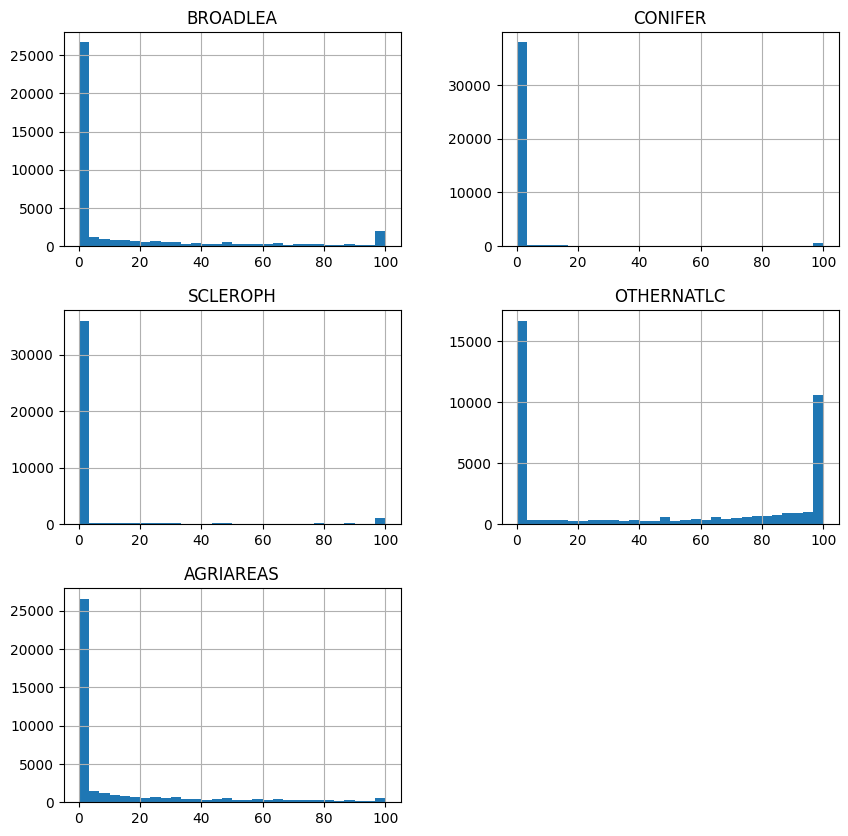

In [54]:
# Echamos un vistazo a las variables de tipología de área quemada

features_select = [feature for feature in features_type if feature not in features_base]
effis_eu[features_select].hist(bins=30, figsize=(10,10));

Transformaciones

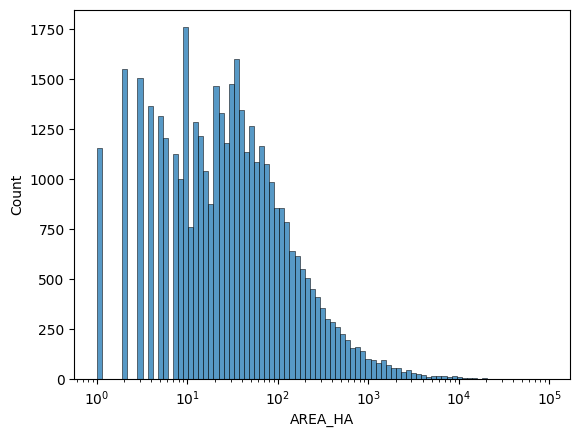

In [55]:
# Aunque la distribución de las variables no es gaussiana, no las trasformaremos,
# ya que HDBSCAN reconoce clusters de densidad variable, y si lo hiciéramos no reconocería los clústeres naturales
# No obstante, el área de los incendios tiene una distribución demsiado radical, 
# por lo que la analizaremos independientemente

sns.histplot(effis_eu, x='AREA_HA', log_scale=True);

In [ ]:
# Si nos fijamos, hay huecos en el área pequeña, no teniendo unos valores continuos hasta alcanzar las 10 ha aproximadamente
# Además, realmente una superficie tan pequeña no deberíamos de considerarla como incendio, y por tanto, filtramos

X = effis_eu.copy()             # Hacemos copia para poder probar diferentes combinaciones rápidamente

X = X.loc[X.AREA_HA > 10]       # Filtramos a áreas quemadas mayores a 10 ha

X.AREA_HA = np.log10(X.AREA_HA) # Aplicamos logaritmo en base 10 (la mayor superficie es de 93,000 ha)

# Para el caso de la tipología de suelo sucede algo similar, aunque en este caso el valor mayoritario es 0

for feature in features_select:
    X[feature] = np.log1p(X[feature])

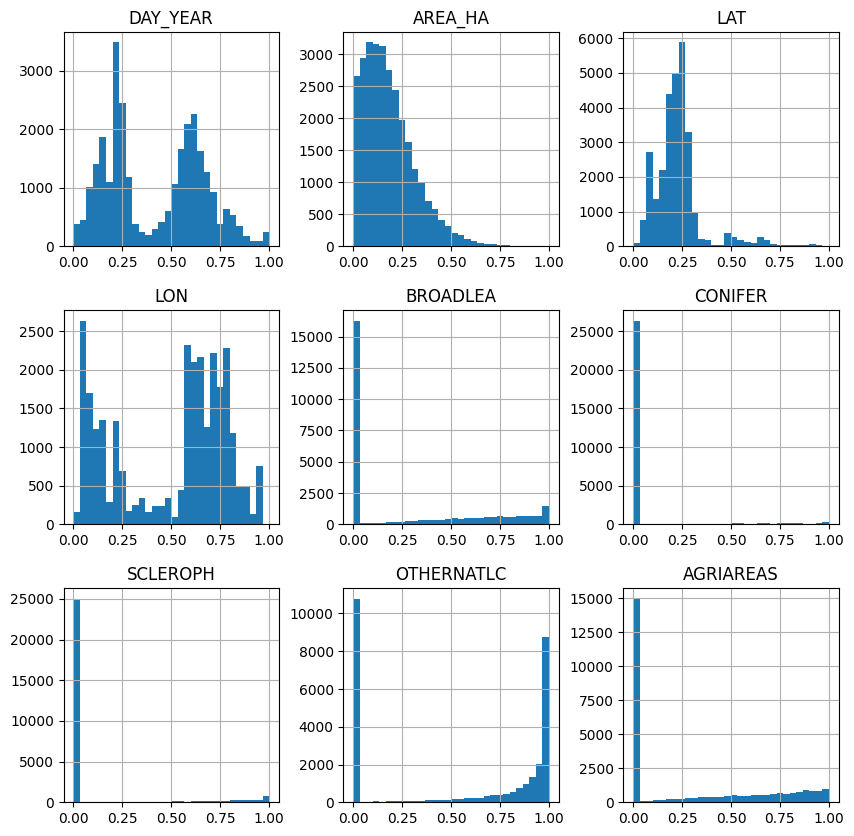

In [57]:
# Escalamos ya que los modelos de cluster se basan en distancia

scaler = MinMaxScaler()
X_esc = pd.DataFrame(scaler.fit_transform(X[features_type]), columns=features_type)

X_esc.hist(bins=30, figsize=(10,10));

In [58]:
# Aproximación del número min de elementos para cada cluster

round(X_esc.shape[0] / 1000)

29

In [59]:
# Entrenamos los modelos y estabecemos el número mínimo de elementos de un cluster en el 0.1 % del dataset

scan_base = HDBSCAN(min_cluster_size=30)
scan_base.fit(X_esc[features_base])

scan_type = HDBSCAN(min_cluster_size=30)
scan_type.fit(X_esc)

c:\Users\Usuario\Documents\GitHub\ML_EFFIS\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Usuario\Documents\GitHub\ML_EFFIS\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Usuario\Documents\GitHub\ML_EFFIS\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Usuario\Documents\GitHub\ML_EFFIS\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,min_cluster_size,30
,min_samples,None
,cluster_selection_epsilon,0.0
,max_cluster_size,0
,metric,'euclidean'
,alpha,1.0
,p,None
,algorithm,'best'
,leaf_size,40
,memory,Memory(location=None)
,approx_min_span_tree,True


In [60]:
# Y comprobamos número de clusteres así como porcentaje de anomalías para cada uno

for name, model in zip(['base', 'type'], [scan_base, scan_type]):
    print(f'Modelo {name}:')
    values, counts = np.unique(model.labels_, return_counts=True)
    num_clusters = max(values)+1
    perc_anomalias = round(counts[0]/len(X_esc)*100, 2)

    print(f'Clusteres: {num_clusters}')
    print(f'Anomalías: {perc_anomalias} %\n')

Modelo base:
Clusteres: 14
Anomalías: 25.91 %

Modelo type:
Clusteres: 38
Anomalías: 45.74 %



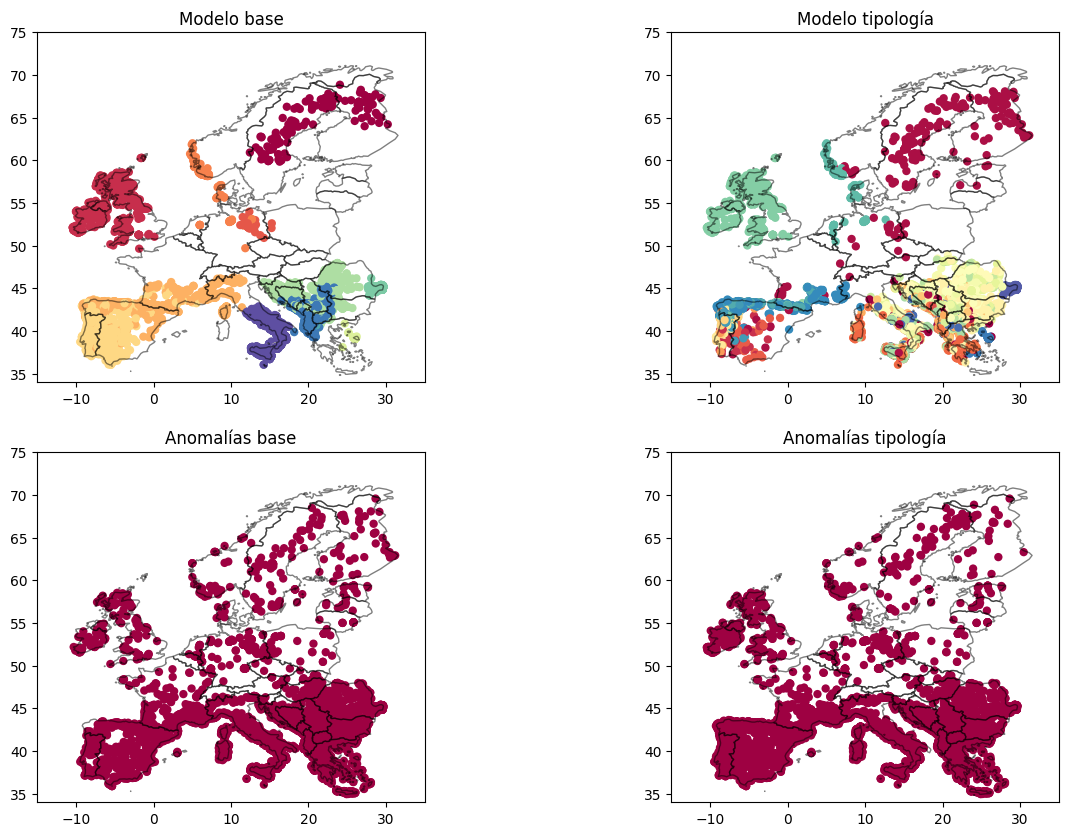

In [61]:
fig, ax = plt.subplots(2,2, figsize=(15, 10))

for name, (index,model) in zip(['base', 'tipología'], enumerate([scan_base, scan_type])):
    X['CLUSTER'] = model.labels_ 
    datos = X

    clusters = datos.loc[datos.CLUSTER != -1]
    anomalias= datos.loc[datos.CLUSTER == -1]

    sns.scatterplot(clusters, x='LON', y='LAT', hue='CLUSTER', edgecolor='none', palette='Spectral', ax=ax[0, index], legend=False)
    sns.scatterplot(anomalias, x='LON', y='LAT', hue='CLUSTER', edgecolor='none', palette='Spectral', ax=ax[1, index], legend=False)

    ax[0, index].set_title(f'Modelo {name}')
    ax[1, index].set_title(f'Anomalías {name}')

    for n in [0,1]:
        ax[n, index].set_ylim(34, 75)
        ax[n, index].set_xlim(-15, 35)
        ax[n, index].set_ylabel('')
        ax[n, index].set_xlabel('')

    # Agregamos el shapefile directamente desde geopandas
    countries.plot(ax=ax[0,index], color='none', edgecolor='k', alpha=0.5)
    countries.plot(ax=ax[1,index], color='none', edgecolor='k', alpha=0.5)

fig.tight_layout;

Representación general de las distribución de incendios bastante buena para el modelo base  
(aunque no refleja la costa mediterránea por ejemplo), a pesar de no poder clusterizar un 25% de los incendios  
  
En el caso de la tipifación, sería útil para ver el detalle a escalas más pequeñas,  
pero a una escala general  nos encontramos con demasiado ruido

In [62]:
# Para temrinar comprobamos persistencia en el modelo base
# Y vemos que los clusteres son poco persistentes

scan_base.cluster_persistence_

array([0.02140862, 0.07760023, 0.00351408, 0.05256589, 0.21444741,
       0.07064105, 0.01512386, 0.00784932, 0.14615384, 0.12951456,
       0.12464691, 0.03673132, 0.07285061, 0.12744643])

#### Optimización

El primer paso será repensar las variables seleccionadas.  
Revisando la diferencia de distribución de 'OTHERNATLC' decido eliminarla por ser demasiado 'general', por tanto, no me discrimina grupos.  

El segundo paso es la transformación de esas variables.  
Tras probar varios métodos que en general añadían demasiado ruido (generando > 100 clusters),  
me fijo en que l distribución de las variables es similar a un capado, pero en el 0,  
y decido realizar un One-Hot-Encoding a cada, ya que son porentajes de áreas con ese tipo de superficie,  
y por tanto, cada incendio tendrá, o no, ese tipo de terreno.

In [249]:
X = effis_eu.copy()
X = X.loc[X.AREA_HA > 10]

# Primero repensamos las features, y descartamos 'OTHERNATLC' por ser demasiado 'generalista' en los incendios
features_select = ['BROADLEA',
                    'CONIFER',
                    'SCLEROPH',
                    'AGRIAREAS']
features_type = features_base + features_select

# Transformamos las features 
X.AREA_HA = np.log10(X.AREA_HA)                                             # Mantenemos la transformación para el área
X[features_select] = (X[features_select] / X[features_select]).fillna(0)    # Dividimos cada feature entre sí para optener valores 0-1

# Escalamos
scaler = MinMaxScaler()
X_esc = pd.DataFrame(scaler.fit_transform(X[features_type]), columns=features_type)

# X_esc.hist(bins=30, figsize=(10,10));

Para el modelo aumento el tamaño mínimo de cada cluster (min_cluster_size)  
y acoto el número mínimo de vecinos que ha de tener cada elemento de un cluster (min_samples).  
De esta forma se intenta reducir el ruido, pero manteniendo el nivel de detalle deseado.

In [250]:
scan_base = HDBSCAN(min_cluster_size=50, min_samples=5)
scan_base.fit(X_esc[features_base])

c:\Users\Usuario\Documents\GitHub\ML_EFFIS\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Usuario\Documents\GitHub\ML_EFFIS\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,min_cluster_size,50
,min_samples,5
,cluster_selection_epsilon,0.0
,max_cluster_size,0
,metric,'euclidean'
,alpha,1.0
,p,None
,algorithm,'best'
,leaf_size,40
,memory,Memory(location=None)
,approx_min_span_tree,True


In [251]:
scan_type = HDBSCAN(min_cluster_size=50, min_samples=5)
scan_type.fit(X_esc[features_type])

c:\Users\Usuario\Documents\GitHub\ML_EFFIS\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Usuario\Documents\GitHub\ML_EFFIS\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,min_cluster_size,50
,min_samples,5
,cluster_selection_epsilon,0.0
,max_cluster_size,0
,metric,'euclidean'
,alpha,1.0
,p,None
,algorithm,'best'
,leaf_size,40
,memory,Memory(location=None)
,approx_min_span_tree,True


In [252]:
for name, model in zip(['base', 'type'], [scan_base, scan_type]):
    print(f'Modelo {name}:')
    values, counts = np.unique(model.labels_, return_counts=True)
    num_clusters = max(values)+1
    perc_anomalias = round(counts[0]/len(X_esc)*100, 2)

    print(f'Clusteres: {num_clusters}')
    print(f'Anomalías: {perc_anomalias} %\n')

Modelo base:
Clusteres: 20
Anomalías: 19.92 %

Modelo type:
Clusteres: 52
Anomalías: 13.85 %



Para el modelo con todos los parámetros vemos un buen balance de número de clusteres (es toda Europa)  
y el porcentaje de anomalías, ya que valores inferiores al 10 % suele arrojar > 100 clusteres

Por último, revisamos el resultado de la clusterización

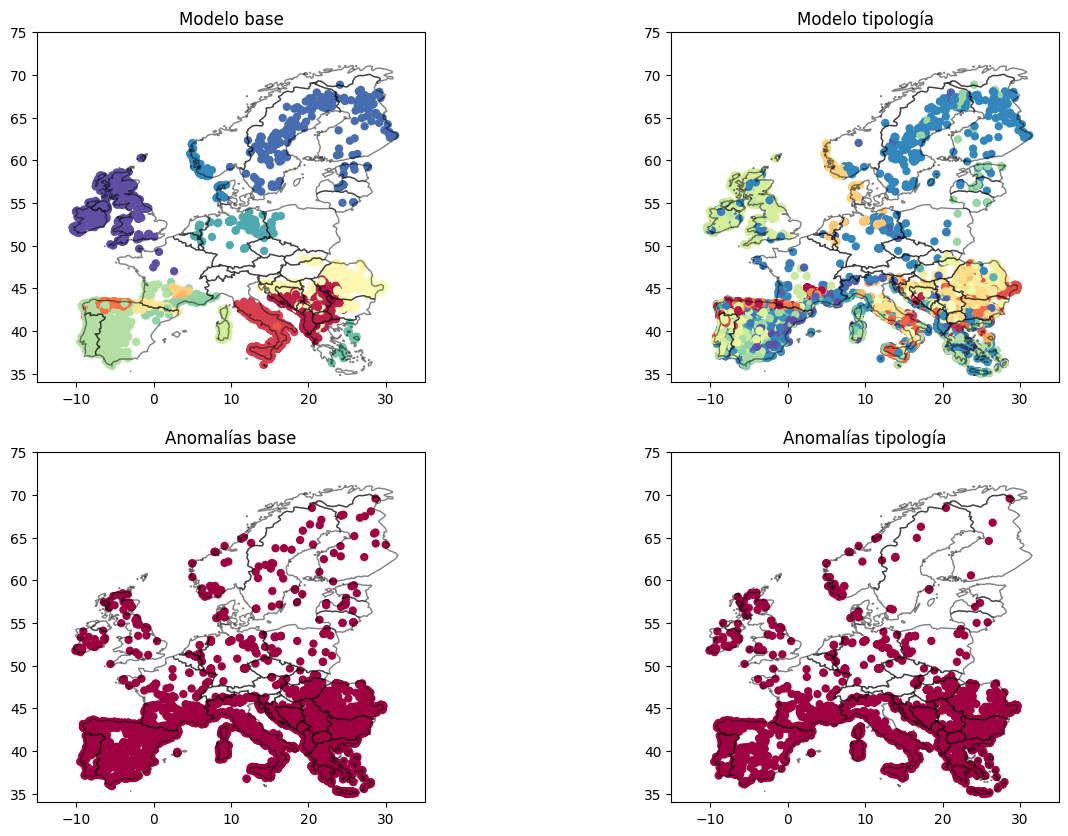

In [253]:
fig, ax = plt.subplots(2,2, figsize=(15, 10))

for name, (index,model) in zip(['base', 'tipología'], enumerate([scan_base, scan_type])):
    X['CLUSTER'] = model.labels_ 
    datos = X

    clusters = datos.loc[datos.CLUSTER != -1]
    anomalias= datos.loc[datos.CLUSTER == -1]

    sns.scatterplot(clusters, x='LON', y='LAT', hue='CLUSTER', edgecolor='none', palette='Spectral_r', ax=ax[0, index], legend=False)
    sns.scatterplot(anomalias, x='LON', y='LAT', hue='CLUSTER', edgecolor='none', palette='Spectral', ax=ax[1, index], legend=False)

    ax[0, index].set_title(f'Modelo {name}')
    ax[1, index].set_title(f'Anomalías {name}')

    for n in [0,1]:
        ax[n, index].set_ylim(34, 75)
        ax[n, index].set_xlim(-15, 35)
        ax[n, index].set_ylabel('')
        ax[n, index].set_xlabel('')

    # Agregamos el shapefile directamente desde geopandas
    countries.plot(ax=ax[0,index], color='none', edgecolor='k', alpha=0.5)
    countries.plot(ax=ax[1,index], color='none', edgecolor='k', alpha=0.5)

fig.tight_layout;

Vemos que las anomalías prácticamente aparecen en todo el mapa, por tanto, puede interpretarse como outliers de cada zona, incendios atípicos

Y una última comprobación para contrastar modelos, revisamos la persistencia de los clusteres

In [254]:
# Por último comprobamos la persistencia de los clusters

persistance(scan_base)

,Clusters,Persistance
4,4,0.322165
11,11,0.251988
9,9,0.227638
17,17,0.191983
14,14,0.126011
2,2,0.110125
15,15,0.104016
10,10,0.101560


In [ ]:
# 21 clusteres de 52 tienen cierta persistencia (> 0.1) y los 6 primeros > 0.2
# En comparación con las otras combinaciones, esta es la más equilibrada

persistance(scan_type).reset_index().drop(columns='index')

,Clusters,Persistance
0,36,0.413858
1,44,0.365610
2,40,0.243898
3,23,0.242530
4,22,0.229375
5,21,0.201217
6,49,0.193551
7,30,0.188045
8,34,0.169592
9,45,0.169367


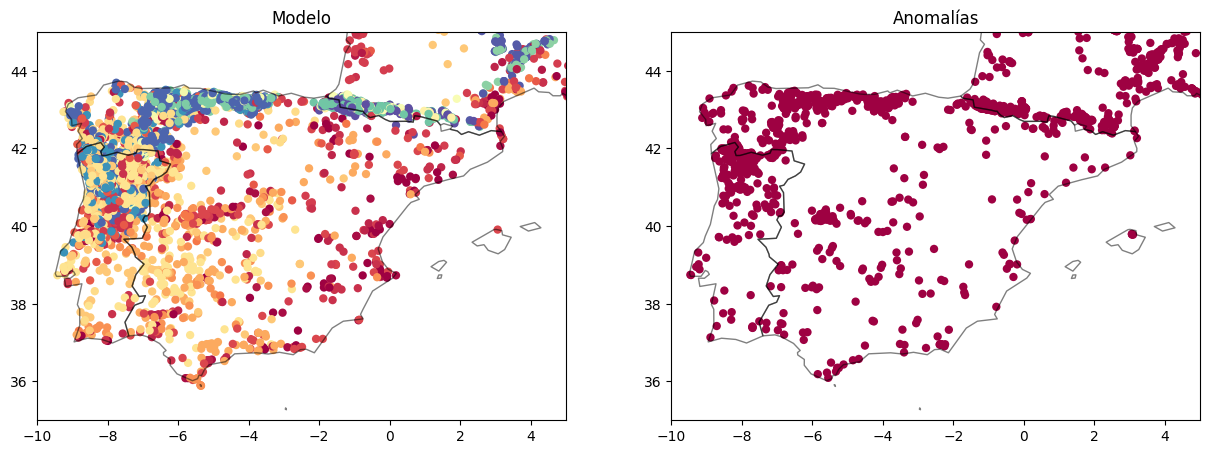

In [258]:
# Ampliemos a un país

datos = X #.loc[(X.COUNTRY == 'Spain') | (X.COUNTRY == 'Portugal')]

fig, ax = plt.subplots(1,2, figsize=(15, 10))

clusters = datos.loc[datos.CLUSTER != -1]
anomalias= datos.loc[datos.CLUSTER == -1]

sns.scatterplot(clusters, x='LON', y='LAT', hue='CLUSTER', edgecolor='none', palette='Spectral', ax=ax[0], legend=False)
sns.scatterplot(anomalias, x='LON', y='LAT', hue='CLUSTER', edgecolor='none', palette='Spectral', ax=ax[1], legend=False)

ax[0].set_title(f'Modelo')
ax[1].set_title(f'Anomalías')

for n in [0,1]:
    ax[n].set_ylim(35, 45)
    ax[n].set_xlim(-10, 5)
    ax[n].set_ylabel('')
    ax[n].set_xlabel('')

    # Agregamos el shapefile directamente desde geopandas
    countries.plot(ax=ax[n], color='none', edgecolor='k', alpha=0.5)

fig.tight_layout;

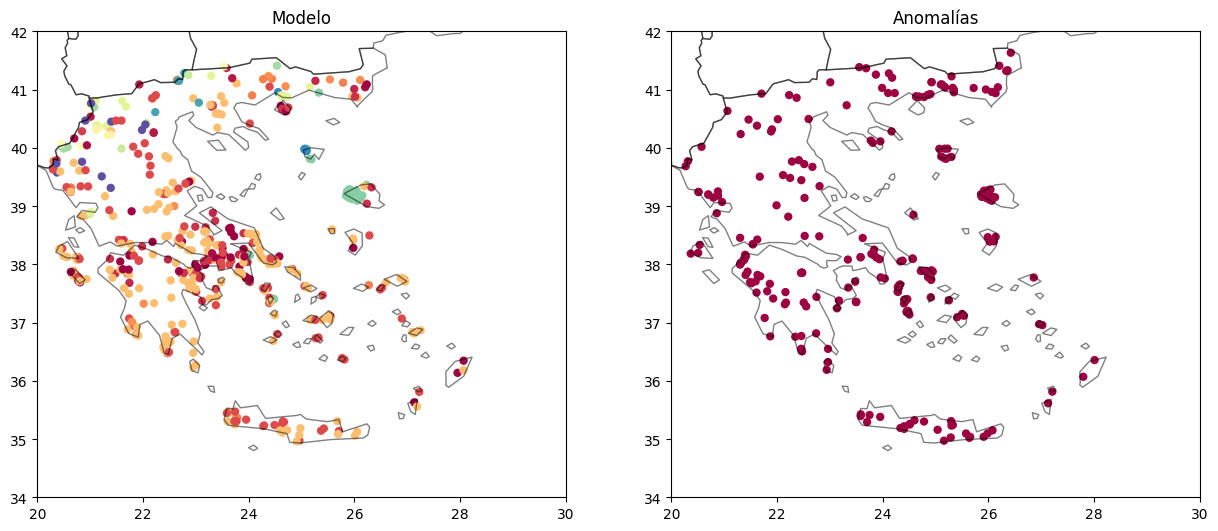

In [259]:
datos = X.loc[(X.COUNTRY == 'Greece') ]

fig, ax = plt.subplots(1,2, figsize=(15, 10))

clusters = datos.loc[datos.CLUSTER != -1]
anomalias= datos.loc[datos.CLUSTER == -1]

sns.scatterplot(clusters, x='LON', y='LAT', hue='CLUSTER', edgecolor='none', palette='Spectral', ax=ax[0], legend=False)
sns.scatterplot(anomalias, x='LON', y='LAT', hue='CLUSTER', edgecolor='none', palette='Spectral', ax=ax[1], legend=False)

ax[0].set_title(f'Modelo')
ax[1].set_title(f'Anomalías')

for n in [0,1]:
    ax[n].set_ylim(34, 42)
    ax[n].set_xlim(20, 30)
    ax[n].set_ylabel('')
    ax[n].set_xlabel('')

    # Agregamos el shapefile directamente desde geopandas
    countries.plot(ax=ax[n], color='none', edgecolor='k', alpha=0.5)

fig.tight_layout;